# Importing Modules

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import ray
import time
import numpy as np

/home/samuel/Coding/distributed-computing/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-07 01:19:35,002	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
ray.init()

2024-10-07 01:27:25,328	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 172.18.0.2:6379...


[2024-10-07 01:27:30,333 E 22379 22379] gcs_rpc_client.h:179: Failed to connect to GCS at address 172.18.0.2:6379 within 5 seconds.


In [3]:
# Baixar o dataset
data = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

In [4]:
# Função de treinamento com diferentes hiperparâmetros
@ray.remote
def treino_random_forest(n_estimators, max_depth):
    # Criar e treinar o modelo
    tempo_inicio = time.time()
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Avaliar o modelo
    predictions = model.predict(X_test)
    mse         = mean_squared_error(y_test, predictions)
    tempo       = time.time() - tempo_inicio
    return (n_estimators, max_depth, mse, tempo)

In [5]:
# Lista de hiperparâmetros para testar
hiperparametros = [(100, 10), (200, 15), (300, 20), (400, 25), (500, 30)]

In [6]:
def busca_centralizada():
    resultados   = []
    tempo_total  = time.time()
    for n, d in hiperparametros:
        tempo_inicio = time.time()
        model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=42)
        model.fit(X_train, y_train)

        # Avaliar o modelo
        predictions = model.predict(X_test)
        mse         = mean_squared_error(y_test, predictions)
        tempo       = time.time() - tempo_inicio
        resultados.append((n, d, mse, tempo))

    return resultados , time.time() - tempo_total

In [7]:
def busca_distribuida():
    tempo_total  = time.time()
    # Executar a busca de hiperparâmetros em paralelo
    resultados = ray.get([treino_random_forest.remote(n, d) for n, d in hiperparametros])
    return resultados, time.time() - tempo_total

In [8]:
resultados_centralizado, tempo_total_c = busca_centralizada()
resultados_distribuido, tempo_total_d  = busca_distribuida()

(raylet) [2024-10-07 00:05:21,455 E 84831 84831] (raylet) node_manager.cc:3065: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 6a0391805292df27e1d4f96e82b865b2c2e211277f7824ca89c55b75, IP: 192.168.15.10) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.15.10`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) 
(raylet) [2024-10-07 00:06:21,456 E 84831 84831] (raylet) node_manager.cc:3065: 1 Workers (tasks / actors

Text(0.5, 0, 'Tempo Total (s)')

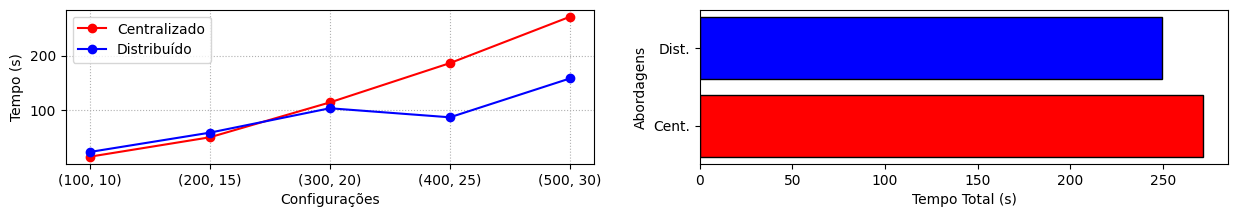

In [9]:
import matplotlib.pyplot as plt
import seaborn

fig, ax = plt.subplots(1, 2, figsize=(15, 2))

ax[0].plot(np.cumsum(np.array(resultados_centralizado)[:,-1]), label='Centralizado', color='r', marker='o')
ax[0].plot(np.array(resultados_distribuido)[:,-1], label='Distribuído', color='b', marker='o')
ax[0].grid(True, linestyle=':')
ax[0].legend()
ax[0].set_xlabel('Configurações')
ax[0].set_ylabel('Tempo (s)')
ax[0].set_xticks([0, 1, 2, 3, 4], ('(100, 10)', '(200, 15)', '(300, 20)', '(400, 25)', '(500, 30)'))

ax[1].barh(['Cent.', 'Dist.'], [tempo_total_c, tempo_total_d], ec='k', color=['r', 'b'])
ax[1].set_ylabel('Abordagens')
ax[1].set_xlabel('Tempo Total (s)')

In [1]:
PORTA=8080
PORTA_DASHBOARD=8081

In [4]:
ray start --head --node-ip-address="IP" --port=PORTA --dashboard-host="0.0.0.0" --dashboard-port=PORTA_DASHBOARD

SyntaxError: invalid syntax (1202001024.py, line 1)